<br>

# 11주차 과제 2번

<br><br>

# 5. Lab: CNN with TensorFlow (MNIST)
<br>


- MNIST without flattening
- To classify handwritten digits


<br>
<center>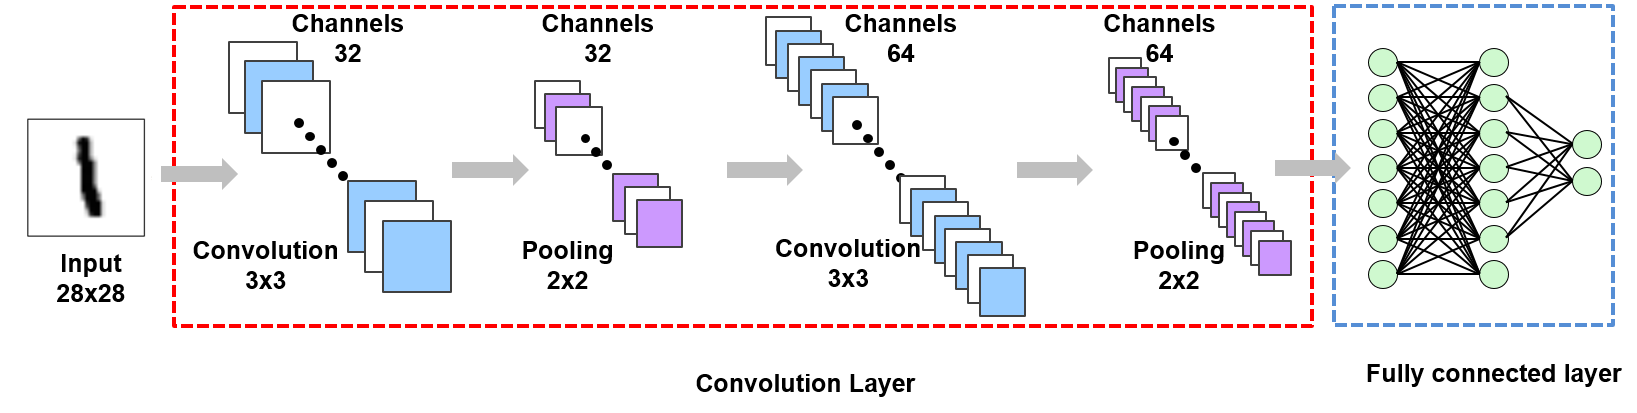</center>
<br>
<br>

In [1]:
## 5.1. Training
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [2]:
mnist = tf.keras.datasets.mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x, test_x = train_x/255.0, test_x/255.0
train_x.shape
train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [3]:
# input layer
input_h =  28  # input height
input_w =  28  # input width
input_ch = 1   # input channel : Gray scale


# 1st convolution layer
k1_h = 3
k1_w = 3
k1_ch = 32
p1_h = 2
p1_w = 2
# (None, 14, 14, 32)

# 2nd convolution layer
k2_h = 3
k2_w = 3
k2_ch = 64
p2_h = 2
p2_w = 2
# (None, 7, 7, 64)

#3th convolution layer
k3_h = 3
k3_h = 3
k3_ch = 128
p3_h = 2
p3_w = 2
# (None, 7, 7, 128)

In [4]:
# [batch, height, width, channels]

def net(x, weights, biases):
    # 1st convolution layer
    conv1 = tf.nn.conv2d(x, weights['w1'], strides=[1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(conv1 + biases['b1'])
    maxp1 = tf.nn.max_pool(conv1, ksize=[1, p1_h, p1_w, 1], strides=[1, p1_h, p1_w, 1], padding='VALID')
#   maxp1 = tf.nn.max_pool(conv1, ksize=[1,p1_h,p1_w,1], strides=[1,p1_h,p1_w,1], padding='VALID')

    # 2nd convolution layer
    conv2 = tf.nn.conv2d(maxp1, weights['w2'], strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(conv2 + biases['b2'])
    maxp2 = tf.nn.max_pool(conv2, ksize=[1, p2_h, p2_w, 1], strides=[1, p2_h, p2_w, 1], padding='VALID')

    conv3 = tf.nn.conv2d(maxp2, weights['w3'], strides=[1, 1, 1, 1], padding='SAME')
    conv3 = tf.nn.relu(conv3 + biases['b3'])
    maxp3 = tf.nn.max_pool(conv3, ksize=[1, p3_h, p3_w, 1], strides=[1, p3_h, p3_w, 1], padding='SAME')

    maxp3_flatten = tf.reshape(maxp3,[-1, 4 * 4 * 128])

    # Fully connected layer1
    FC1 = tf.add(tf.matmul(maxp3_flatten, weights['wd1']), biases['bd1'])
    FC1 = tf.nn.relu(FC1)
    
    
    # Fully connected layer2
    
    FC2 = tf.add(tf.matmul(FC1, weights['wd2']), biases['bd2'])
    FC2 = tf.nn.relu(FC2)
    
    # output layer
    output = tf.add(tf.matmul(FC2, weights['out']), biases['out'])
    
    return output

In [5]:
# Loss function
tf.compat.v1.disable_eager_execution()
x = tf.compat.v1.placeholder(tf.float32, shape=[None, 28, 28, 1])
y = tf.compat.v1.placeholder(tf.float32, shape=[None, 10])

weights = {
    'w1': tf.Variable(tf.random.truncated_normal([3, 3, 1, 32])),  # 1채널 → 32채널
    'w2': tf.Variable(tf.random.truncated_normal([3, 3, 32, 64])), # 32채널→ 64채널
    'w3': tf.Variable(tf.random.truncated_normal([3, 3, 64, 128])),# 64채널→ 128채널
    'wd1': tf.Variable(tf.random.truncated_normal([4*4*128, 256])),
    'wd2': tf.Variable(tf.random.truncated_normal([256, 625])),
    'out': tf.Variable(tf.random.truncated_normal([625, 10]))
}

biases = {
    'b1': tf.Variable(tf.random.truncated_normal([32])),
    'b2': tf.Variable(tf.random.truncated_normal([64])),
    'b3': tf.Variable(tf.random.truncated_normal([128])),
    'bd1': tf.Variable(tf.random.truncated_normal([256])),
    'bd2': tf.Variable(tf.random.truncated_normal([625])),
    'out': tf.Variable(tf.random.truncated_normal([10]))
}

LR = 0.001
pred = net(x, weights, biases)
loss = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)
loss = tf.reduce_mean(loss)

optm = tf.compat.v1.train.AdamOptimizer(learning_rate=LR).minimize(loss)

# Optimization

n_batch = 50
n_iter = 3000
n_prt = 250

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

loss_record_train = []
loss_record_test = []

In [6]:
for epoch in range(n_iter):
    # Get a random batch of training data
    batch_indices = np.random.choice(train_x.shape[0], size=n_batch, replace=False)
    batch_x = train_x[batch_indices]
    batch_y = train_y[batch_indices]

    batch_x = np.reshape(batch_x, (-1, 28, 28, 1))
    # Convert labels to one-hot encoding if necessary
    batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=10)  # Adjust num_classes if needed

    sess.run(optm, feed_dict={x : batch_x, y : batch_y})

    if epoch % n_prt == 0:
        # Get a random batch of test data
        test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
        test_batch_x = test_x[test_batch_indices]
        test_batch_y = test_y[test_batch_indices]

        test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))
        # Convert labels to one-hot encoding if necessary
        test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)  # Adjust num_classes if needed
        c1 = sess.run(loss, feed_dict={x: batch_x, y: batch_y})
        c2 = sess.run(loss, feed_dict={x: test_batch_x, y: test_batch_y})

        loss_record_train.append(c1)
        loss_record_test.append(c2)
        print("Iter : {}".format(epoch))
        print("Train Loss : {}".format(c1))
        print("Cost : {}".format(c2))

Iter : 0
Train Loss : 2380325.25
Cost : 2567476.5
Iter : 250
Train Loss : 45620.80859375
Cost : 54716.26171875
Iter : 500
Train Loss : 6056.22265625
Cost : 14726.4248046875
Iter : 750
Train Loss : 14021.4208984375
Cost : 15224.6376953125
Iter : 1000
Train Loss : 866.49267578125
Cost : 9230.6220703125
Iter : 1250
Train Loss : 8621.2724609375
Cost : 18459.1328125
Iter : 1500
Train Loss : 1933.978759765625
Cost : 3820.1201171875
Iter : 1750
Train Loss : 2795.710693359375
Cost : 10092.8984375
Iter : 2000
Train Loss : 9817.5185546875
Cost : 0.0
Iter : 2250
Train Loss : 2643.340576171875
Cost : 7105.44677734375
Iter : 2500
Train Loss : 3033.49072265625
Cost : 0.0
Iter : 2750
Train Loss : 6969.2255859375
Cost : 15856.712890625


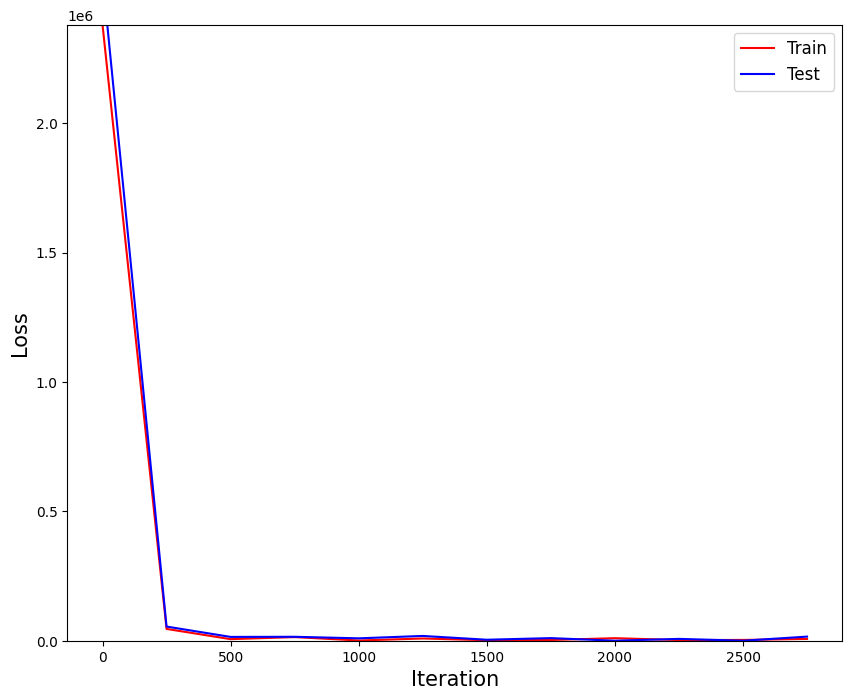

In [7]:
plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, 'r', label = 'Train')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, 'b', label = 'Test')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

<br>

## 5.2. Testing or Evaluating

In [8]:
# Evaluation
# Get a random batch of test data

test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))  # Reshape the batch if needed
# Convert labels to one-hot encoding if necessary
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)  # Adjust num_classes if needed

my_pred = sess.run(pred, feed_dict={x: test_batch_x.reshape(-1, 28, 28, 1)})
my_pred = np.argmax(my_pred, axis=1)

labels = np.argmax(test_batch_y, axis=1)

accr = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}".format(accr*100))
# Get a random batch of test data
n_batch = 1
test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))  # Reshape the batch if needed
# Convert labels to one-hot encoding if necessary
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)  # Adjust num_classes if needed

logits = sess.run(tf.nn.softmax(pred), feed_dict={x: test_batch_x.reshape(-1, 28, 28, 1)})
predict = np.argmax(logits)


Accuracy : 96.0


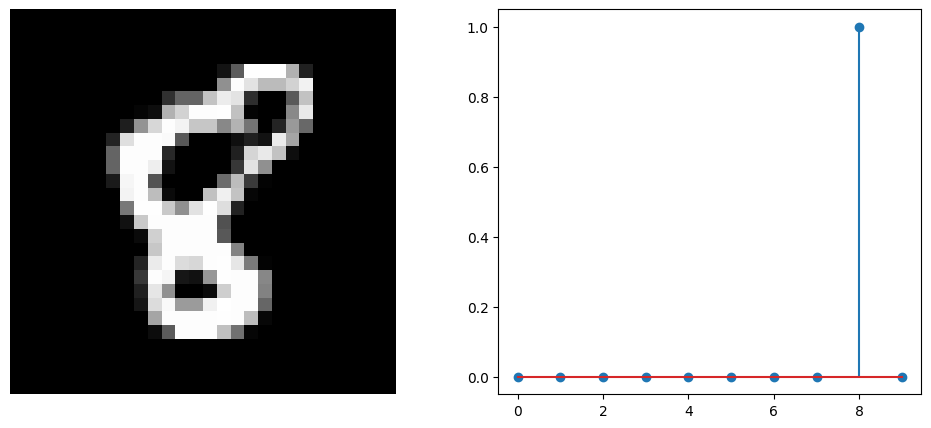

In [9]:
plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
plt.imshow(test_batch_x.reshape(28, 28), 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.stem(logits.ravel())
plt.show()

In [10]:
np.set_printoptions(precision = 2, suppress = True)
print('Prediction : {}'.format(predict))
print('Probability : {}'.format(logits.ravel()))

Prediction : 8
Probability : [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


# 실습(Debugging)

Iter : 0
Train Loss : 1221053.8750, Train Accuracy : 16.00%
Test  Loss : 1255170.5000, Test  Accuracy : 2.00%
Iter : 250
Train Loss : 25743.7891, Train Accuracy : 84.00%
Test  Loss : 14989.3350, Test  Accuracy : 86.00%
Iter : 500
Train Loss : 2064.7454, Train Accuracy : 96.00%
Test  Loss : 14849.4502, Test  Accuracy : 86.00%
Iter : 750
Train Loss : 7447.9600, Train Accuracy : 90.00%
Test  Loss : 11365.1035, Test  Accuracy : 92.00%
Iter : 1000
Train Loss : 23270.9922, Train Accuracy : 92.00%
Test  Loss : 16730.5938, Test  Accuracy : 92.00%
Iter : 1250
Train Loss : 6748.2900, Train Accuracy : 94.00%
Test  Loss : 3774.3806, Test  Accuracy : 94.00%
Iter : 1500
Train Loss : 1880.1539, Train Accuracy : 96.00%
Test  Loss : 11206.2090, Test  Accuracy : 92.00%
Iter : 1750
Train Loss : 6250.2705, Train Accuracy : 94.00%
Test  Loss : 1630.0387, Test  Accuracy : 98.00%
Iter : 2000
Train Loss : 4647.2285, Train Accuracy : 96.00%
Test  Loss : 16460.5020, Test  Accuracy : 92.00%
Iter : 2250
Train Los

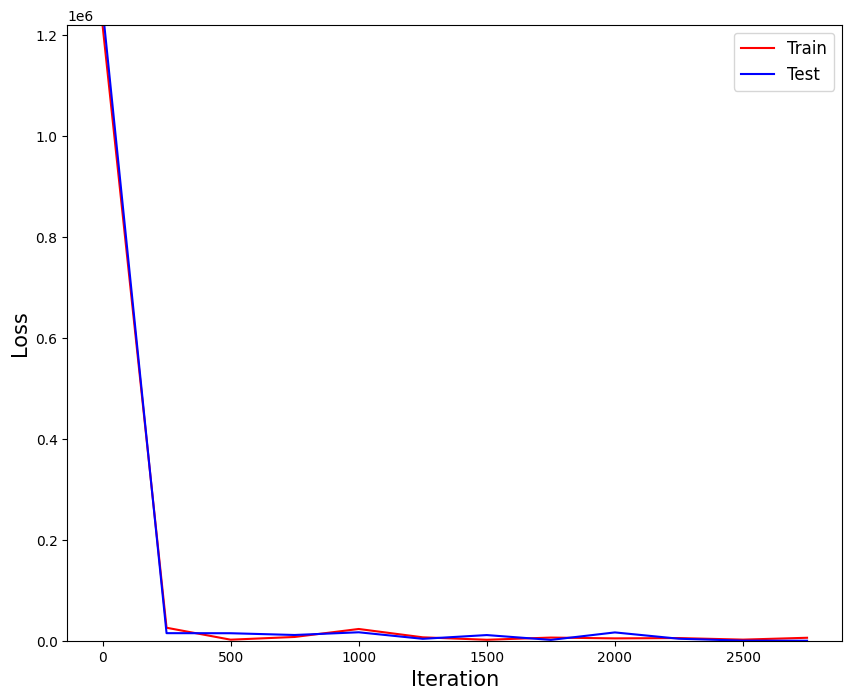

In [11]:
# Optimization

n_batch = 50
n_iter = 3000
n_prt = 250

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

loss_record_train = []
loss_record_test = []
acc_record_train = []
acc_record_test = []

for epoch in range(n_iter):
    idx = np.random.choice(train_x.shape[0], size=n_batch, replace=False)
    train_batch_x = train_x[idx]
    train_batch_y = train_y[idx]
    
    train_batch_y = to_categorical(train_batch_y, num_classes=10)
    
    sess.run(optm, feed_dict={x:train_batch_x, y:train_batch_y})

    if epoch % n_prt == 0:
        test_idx = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
        test_batch_x = test_x[test_idx]
        test_batch_y = test_y[test_idx]
        test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))
        
        test_batch_y = to_categorical(test_batch_y, num_classes=10)
        
        c1 = sess.run(loss, feed_dict={x:train_batch_x, y:train_batch_y})
        c2 = sess.run(loss, feed_dict={x:test_batch_x, y:test_batch_y})
        
        # Accuracy 계산
        correct_pred_train = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        accuracy_train = tf.reduce_mean(tf.cast(correct_pred_train, tf.float32))
        train_acc = sess.run(accuracy_train, feed_dict={x:train_batch_x, y:train_batch_y})

        correct_pred_test = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        accuracy_test = tf.reduce_mean(tf.cast(correct_pred_test, tf.float32))
        test_acc = sess.run(accuracy_test, feed_dict={x:test_batch_x, y:test_batch_y})

        loss_record_train.append(c1)
        loss_record_test.append(c2)
        acc_record_train.append(train_acc)
        acc_record_test.append(test_acc)
        
        print("Iter : {}".format(epoch))
        print("Train Loss : {:.4f}, Train Accuracy : {:.2f}%".format(c1, train_acc * 100))
        print("Test  Loss : {:.4f}, Test  Accuracy : {:.2f}%".format(c2, test_acc * 100))

plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, 'r', label = 'Train')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, 'b', label = 'Test')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

In [12]:
print("Train_Accuracy : {:.2f}%".format(train_acc * 100))
print("Test_Accuracy : {:.2f}%".format(test_acc * 100))

Train_Accuracy : 98.00%
Test_Accuracy : 100.00%
